### Forecasting in Aquaponics

Libraries and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

mpl.rcParams['figure.figsize'] = (14, 8)
mpl.rcParams['axes.grid'] = True

np.random.seed(10)

## Data adquisition and pre-processing

### Data adquisition

In [28]:
def read_file(textfile):
    df = pd.read_csv(textfile, sep="\t")
    df.drop(df.columns[0], axis=1, inplace=True)
    print('Dataset ready')
    return df

textfile = "dataset_aquaponics_03232021_04232021.txt"
df = read_file(textfile)

Dataset ready


Organize data in columns

In [29]:

df_grouped = pd.pivot_table(df, index = 'DateTime', columns = 'Label', values = 'Value')
df_grouped.index = pd.to_datetime(df_grouped.index)

start_date = pd.to_datetime('2021-03-23 00:00:00')
end_date = pd.to_datetime('2021-03-30 23:59:59')

df_grouped = df_grouped.loc[start_date:end_date]
print(df_grouped.head)

<bound method NDFrame.head of Label                      1          2    3       4       5          6    \
DateTime                                                                    
2021-03-23 00:00:20  18.524000  64.557780  0.0  6.6465  6.6854  42.482574   
2021-03-23 00:00:45  18.495003  64.883330  0.0  6.6484  6.6854  42.491630   
2021-03-23 00:06:26  18.386000  64.239006  0.0  6.6450  6.6895  47.371370   
2021-03-23 00:06:52  18.400002  64.685560  0.0  6.6450  6.6895  47.368780   
2021-03-23 00:07:18  18.406000  64.963330  0.0  6.6430  6.6911  47.363903   
...                        ...        ...  ...     ...     ...        ...   
2021-03-30 23:58:00  19.687500  58.212227  0.0  6.6239  6.6624  38.970795   
2021-03-30 23:58:25  19.668000  58.220000  0.0  6.6239  6.6624  38.967790   
2021-03-30 23:58:50  19.607502  58.213337  0.0  6.6276  6.6624  38.973940   
2021-03-30 23:59:14  19.650002  58.278890  0.0  6.6276  6.6636  38.977730   
2021-03-30 23:59:40  19.596003  58.228890  0.0

Data visualization

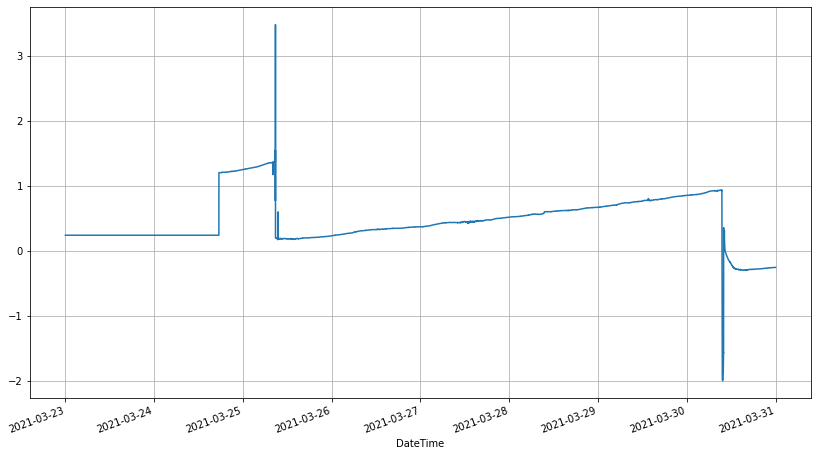

In [39]:
sample_sensor = 93

df_grouped[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()

### Outliers pre-processing

Quantile approach

In [47]:
def remove_outlier(df, low = 0.05, high = 0.95):
    
    quant_df = df.quantile([low, high])
    new_df = df.copy()
    new_df = new_df.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & (x < quant_df.loc[high,x.name])], axis=0)
    
    return new_df

new_df = remove_outlier(df_grouped[93])

new_df[sample_sensor].plot(x = 'DateTime', y = 'Value', kind = 'line')
plt.xticks(rotation=20)
plt.show()


TypeError: <lambda>() got an unexpected keyword argument 'axis'

### Selecting target data and relevant features

Target variables:

* 4     = pH sump B
* 5     = pH sump A
* 8     = % oxygen B
* 9     = % oxygen A
* 18    = C02
* 93*   = Weight cell 1
* 99*   = Nitrate B 
* 100*  = Ammonia B
* 103*  = Nitrate A 
* 104*  = Ammonia A
* sensors are not online yet*

In [5]:
# label_target = {4: 'pH sump B', 
#                 5: 'pH sump A', 
#                 8: '% oxygen B', 
#                 9: '% oxygen A', 
#                 18: 'C02'}

label_target = {4: 'pH sump B', 8: '% oxygen B'}

Delete constant or corrupted-data columns

In [6]:
drop_signal = [12, 13, 14, 15, 22, 23, 24, 25, 32, 33, 35, 42, 43, 44, 46, 48, 49, 56, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 93, 97, 98, 99, 100, 101, 103, 104, 105, 106, 111, 112, 113, 114]
df_grouped  = df_grouped.drop(columns = drop_signal)
print(df_grouped.first)

<bound method NDFrame.first of Label                      1          2    3       4       5          6    \
DateTime                                                                    
2021-03-23 00:00:20  18.524000  64.557780  0.0  6.6465  6.6854  42.482574   
2021-03-23 00:00:45  18.495003  64.883330  0.0  6.6484  6.6854  42.491630   
2021-03-23 00:06:26  18.386000  64.239006  0.0  6.6450  6.6895  47.371370   
2021-03-23 00:06:52  18.400002  64.685560  0.0  6.6450  6.6895  47.368780   
2021-03-23 00:07:18  18.406000  64.963330  0.0  6.6430  6.6911  47.363903   
...                        ...        ...  ...     ...     ...        ...   
2021-03-30 23:58:00  19.687500  58.212227  0.0  6.6239  6.6624  38.970795   
2021-03-30 23:58:25  19.668000  58.220000  0.0  6.6239  6.6624  38.967790   
2021-03-30 23:58:50  19.607502  58.213337  0.0  6.6276  6.6624  38.973940   
2021-03-30 23:59:14  19.650002  58.278890  0.0  6.6276  6.6636  38.977730   
2021-03-30 23:59:40  19.596003  58.228890  0.

Correlation analysis

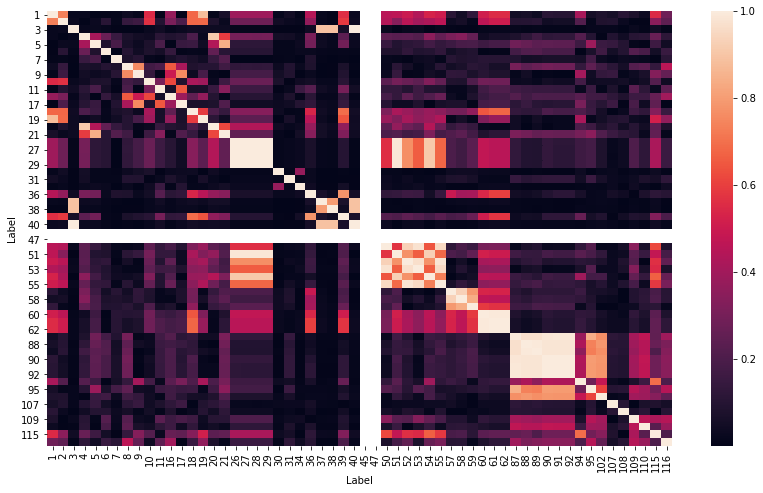

<bound method NDFrame.first of Label                   4       5          6       8       9       16   \
DateTime                                                                 
2021-03-23 00:00:20  6.6465  6.6854  42.482574  103.41  98.432  10.710   
2021-03-23 00:00:45  6.6484  6.6854  42.491630  103.43  98.473  10.712   
2021-03-23 00:06:26  6.6450  6.6895  47.371370  103.20  98.340  10.673   
2021-03-23 00:06:52  6.6450  6.6895  47.368780  103.20  98.340  10.673   
2021-03-23 00:07:18  6.6430  6.6911  47.363903  103.18  98.340  10.673   
...                     ...     ...        ...     ...     ...     ...   
2021-03-30 23:58:00  6.6239  6.6624  38.970795  102.47  98.274  10.786   
2021-03-30 23:58:25  6.6239  6.6624  38.967790  102.47  98.274  10.786   
2021-03-30 23:58:50  6.6276  6.6624  38.973940  102.39  98.239  10.775   
2021-03-30 23:59:14  6.6276  6.6636  38.977730  102.39  98.239  10.775   
2021-03-30 23:59:40  6.6318  6.6636  38.973633  102.24  98.284  10.757   

Label 

In [7]:
corr_mat = np.abs(df_grouped.corr(method='pearson'))
sns.heatmap(corr_mat)
plt.show()

corr_thl = 0.25
corr_label = np.zeros(df_grouped.shape[1])

for i in label_target:
    corr_label = corr_label | (corr_mat[i] > corr_thl)

df_grouped = df_grouped.loc[:, corr_label]
print(df_grouped.first)

Describe  dataset

In [8]:
print(df_grouped.describe().transpose())

         count         mean         std          min          25%  \
Label                                                               
4      13400.0     6.675519    0.037318     6.513600     6.649875   
5      13400.0     6.689255    0.022585     6.150000     6.677700   
6      13400.0    45.719112    2.432669    37.278908    44.007112   
8      13400.0   101.141496    1.629265    97.799000   100.200000   
9      13400.0    95.709665    1.439429    91.044000    94.781000   
16     13400.0    10.750255    0.222274    10.000000    10.626000   
17     13400.0    10.047162    0.205357     9.112200     9.945975   
20     13400.0     7.813354    6.497055     0.000000     1.549959   
21     13400.0     3.600445    3.218044     0.000000     0.674963   
26     13400.0   216.192612  207.995265     0.000000     0.000000   
27     13400.0   216.170224  207.962147     0.000000     0.000000   
28     13400.0   225.793657  217.181300     0.000000     0.000000   
29     13400.0   216.170224  207.9

Split dataset: train, validation and test

In [9]:
total_data = len(df_grouped)

train_perc, val_perc, test_perc = 0.7, 0.2, 0.1

train_df    = df_grouped[0:int(total_data*train_perc)]
val_df      = df_grouped[int(total_data*train_perc):int(total_data*(train_perc + val_perc))]
test_df     = df_grouped[int(total_data*(train_perc + val_perc)):total_data]

Mean-STD normalization

In [10]:
def f_normalize_meanstd(df, train_df):
    norm_mean   = train_df.mean()
    norm_std    = train_df.std()
    
    norm_df = (df - norm_mean) / norm_std
    return norm_df

def f_inv_normalize_meanstd(norm_df, train_df):
    norm_mean   = train_df.mean()
    norm_std    = train_df.std()
    
    df = norm_df * norm_std + norm_mean
    return df

norm_train_df   = f_normalize_meanstd(train_df, train_df)
norm_val_df     = f_normalize_meanstd(val_df, train_df)
norm_test_df    = f_normalize_meanstd(test_df, train_df)

Min-max normalization

In [11]:
def f_normalize_minmax(df, train_df):
    norm_df = (df - train_df.min()) / (train_df.max() - train_df.min())
    return norm_df

def f_inv_normalize_minmax(norm_df, train_df):
    df = norm_df * (train_df.max() - train_df.min()) + train_df.min()
    return df

norm_train_df   = f_normalize_minmax(train_df, train_df)
norm_val_df     = f_normalize_minmax(val_df, train_df)
norm_test_df    = f_normalize_minmax(test_df, train_df)

Show tails with box plot

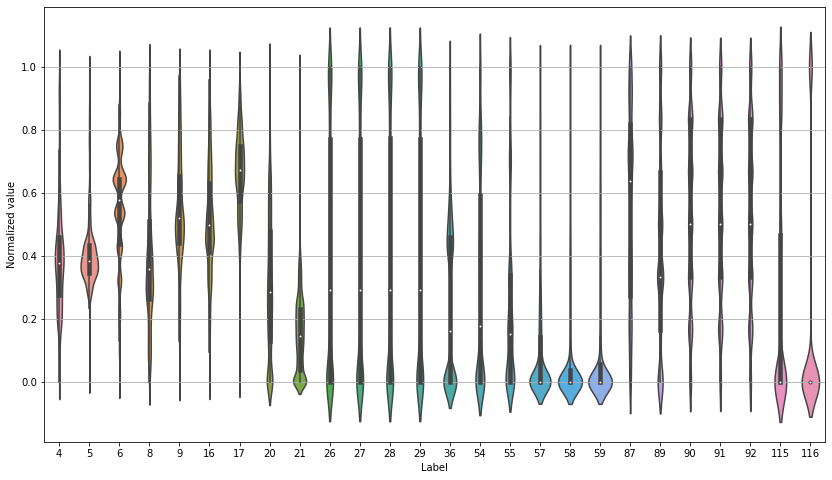

In [12]:
melt_train_df = norm_train_df.melt(var_name = 'Label', value_name = 'Normalized value')
plt.figure()
ax = sns.violinplot(x = 'Label', y = 'Normalized value', data = melt_train_df)
plt.show()

Create input and target dataframe - Window generation

In [13]:
n_hour_data = 65 # 65 entries ~ 1 hour - There is a variable sampling frecuency
n_hours_in  = 1
n_hours_out = 1

input_width     = n_hour_data * n_hours_in 
label_width     = n_hour_data * n_hours_out 
offset_width    = 1 # 1 as default

def f_window_gen(df, label_target, input_width, label_width, offset_width):

    time_range = df.index
    data = []
    target = []

    data_time = []
    target_time = []

    for i in range(len(time_range) - (input_width + offset_width + label_width)):
        range_data = df.loc[time_range[i]:time_range[input_width + i]].values
        data.append(range_data)
        data_time.append(time_range[i:input_width + i])

        range_target = df[label_target].loc[time_range[input_width + offset_width + i: input_width + offset_width + label_width + i]].values
        target.append(range_target.flatten('C'))
        target_time.append(time_range[input_width + offset_width + i: input_width + offset_width + label_width + i])

    data = np.array(data)
    target = np.array(target)

    return data, target, data_time, target_time

train_data, train_target, train_data_time, train_target_time = f_window_gen(norm_train_df, label_target, input_width, label_width, offset_width)
val_data, val_target, val_data_time, val_target_time = f_window_gen(norm_val_df, label_target, input_width, label_width, offset_width)
test_data, test_target, test_data_time, test_target_time = f_window_gen(norm_test_df, label_target, input_width, label_width, offset_width)

Plotting - Normalized values

In [14]:
def plot_results(label_target, label_time, label, results):
    n_label = np.int(len(label_target))
    n_time = np.int(label_time.shape[0])

    m_label = label.reshape(n_time, n_label)
    m_results = results.reshape(n_time, n_label)

    sensor_tag = list(label_target.values())

    fig, ax = plt.subplots(n_label, sharex = 'all')

    for i in range(n_label):
        ax[i].plot(label_time, m_label[:, i], color = 'blue', label = 'Real')
        ax[i].plot(label_time, m_results[:, i], color = 'orange', label = 'Prediction')
        ax[i].set_ylabel(sensor_tag[i])

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('Day - Time')
    plt.show()

    pass

Plotting - History

In [15]:
def plot_history(history):

    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    fig, ax = plt.subplots(2, sharex = 'all')

    # Plot training and validation accuracy per epoch
    ax[0].plot(epochs, acc, label = 'Training')
    ax[0].plot(epochs, val_acc, label = 'Validation')
    ax[0].title.set_text('Training and validation MAE')

    # Plot training and validation loss per epoch
    ax[1].plot(epochs, loss, label = 'Training')
    ax[1].plot(epochs, val_loss, label = 'Validation')
    ax[1].title.set_text('Training and validation loss')

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'center right')
    plt.xticks(rotation=20)
    plt.xlabel('epochs')
    plt.show()

## Model architecture

### Linear model

In [16]:
def f_linear_model(label_target, label_width):
    linear_model = tf.keras.Sequential([
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units = 40),
                    tf.keras.layers.Dense(units = 15),
                    tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return linear_model

linear_model = f_linear_model(label_target, label_width)

### MLP model

In [17]:
def f_mlp_model(label_target, label_width):
    mlp_model = tf.keras.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units = 65*10, activation = 'relu'),
                tf.keras.layers.Dense(units = 65*5, activation = 'relu'),
                tf.keras.layers.Dense(units = 65, activation = 'relu'),
                tf.keras.layers.Dense(units = len(label_target) * label_width)])
    return mlp_model
    
mlp_model = f_mlp_model(label_target, label_width)

### RNN - LSTM

In [18]:
def f_lstm_model(input_shape, output_shape):
    lstm_model = tf.keras.Sequential([
                tf.keras.layers.LSTM(units = 65 * 5, input_shape = input_shape),
                tf.keras.layers.Dense(output_shape)])
    return lstm_model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
lstm_model = f_lstm_model(input_shape, output_shape)

### RNN - GRU

In [19]:
def f_gru_model(input_shape, output_shape):
    lstm_model = tf.keras.Sequential([
                tf.keras.layers.GRU(units = 65 * 5, input_shape = input_shape),
                tf.keras.layers.Dense(output_shape)])
    return lstm_model

input_shape = train_data[0].shape
output_shape = train_target.shape[1]
gru_model = f_gru_model(input_shape, output_shape)

## Deployment

Callbacks

In [20]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

Training method

In [21]:
def compile_and_fit(model, train_data, train_target, val_data, val_target, test_data, test_target, max_epochs, batch_size, test_entry):

    # Add callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                  patience = 4)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
    callbacks = [early_stop, lr_scheduler]

    # Model compile
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])

    # Model fit
    history = model.fit(train_data,
                        train_target,
                        batch_size = batch_size,
                        epochs  = max_epochs,
                        verbose = 2,
                        shuffle = False, 
                        validation_data = (val_data, val_target),
                        callbacks = callbacks)

    model.evaluate(test_data, test_target)

    test_data = np.reshape(test_data[test_entry], (1, test_data[0].shape[0], test_data[0].shape[1]))
    test_prediction = model.predict(test_data)

    return history, test_prediction

max_epochs = 15
batch_size = 36
test_entry = np.random.randint(0, 100)

## Linear model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
257/257 - 1s - loss: 0.1311 - mean_absolute_error: 0.2725 - val_loss: 1.0777 - val_mean_absolute_error: 0.8241

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
257/257 - 0s - loss: 0.0783 - mean_absolute_error: 0.2126 - val_loss: 0.3932 - val_mean_absolute_error: 0.4679

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
257/257 - 0s - loss: 0.0458 - mean_absolute_error: 0.1606 - val_loss: 0.7108 - val_mean_absolute_error: 0.6953

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
257/257 - 0s - loss: 0.0344 - mean_absolute_error: 0.1405 - val_loss: 0.3991 - val_mean_absolute_error: 0.5013

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
257/257 - 0s - loss: 0.0246 - mean_absolute_error: 0.1219 - val_loss: 0.1632

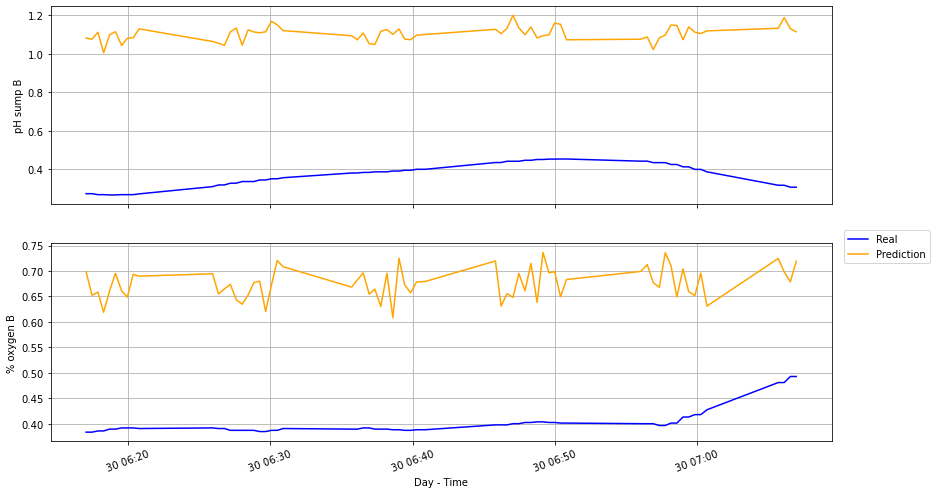

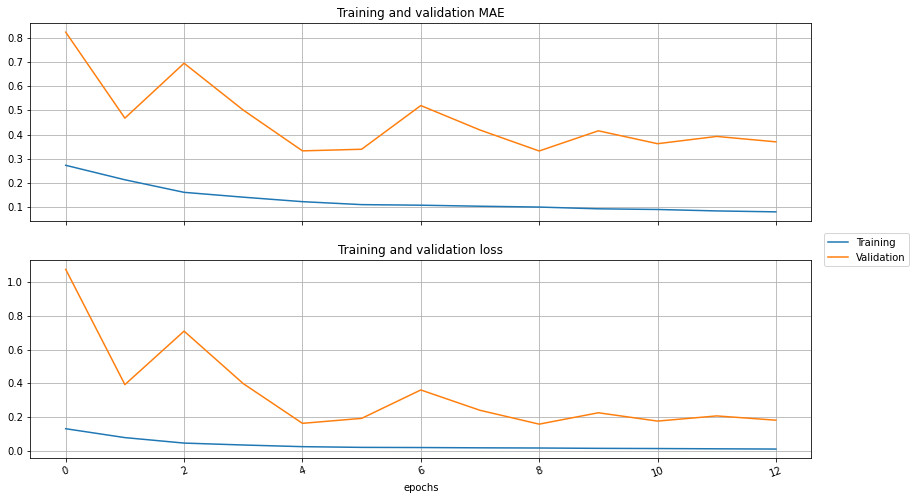

In [22]:
linear_history, linear_prediction = compile_and_fit(linear_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

linear_results = linear_prediction.reshape(label_width, len(label_target))

plot_results(label_target, test_target_time[test_entry], test_target[test_entry], linear_results)

plot_history(linear_history)

## MLP model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
257/257 - 1s - loss: 0.0383 - mean_absolute_error: 0.1340 - val_loss: 0.5081 - val_mean_absolute_error: 0.6191

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
257/257 - 1s - loss: 0.0294 - mean_absolute_error: 0.1315 - val_loss: 0.3038 - val_mean_absolute_error: 0.4423

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
257/257 - 1s - loss: 0.0254 - mean_absolute_error: 0.1224 - val_loss: 0.0982 - val_mean_absolute_error: 0.2672

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
257/257 - 1s - loss: 0.0184 - mean_absolute_error: 0.1035 - val_loss: 0.0989 - val_mean_absolute_error: 0.2393

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
257/257 - 1s - loss: 0.0240 - mean_absolute_error: 0.1147 - val_loss: 0.0997

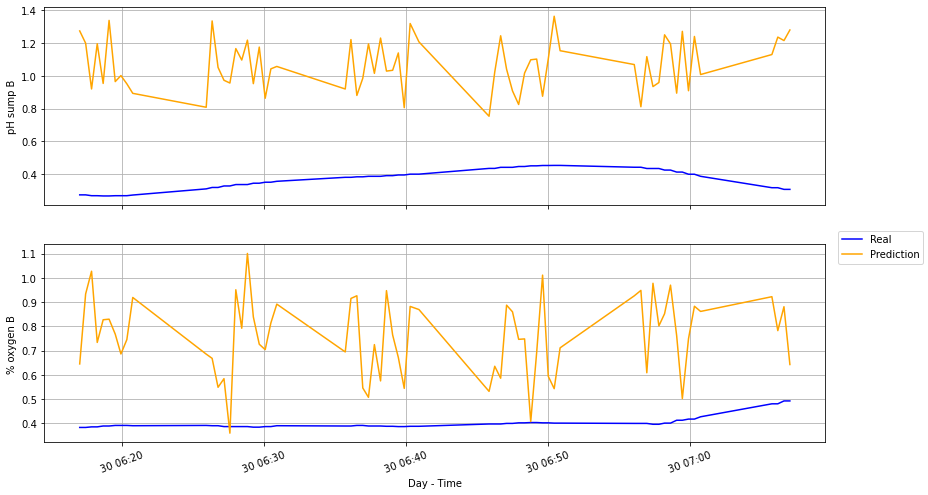

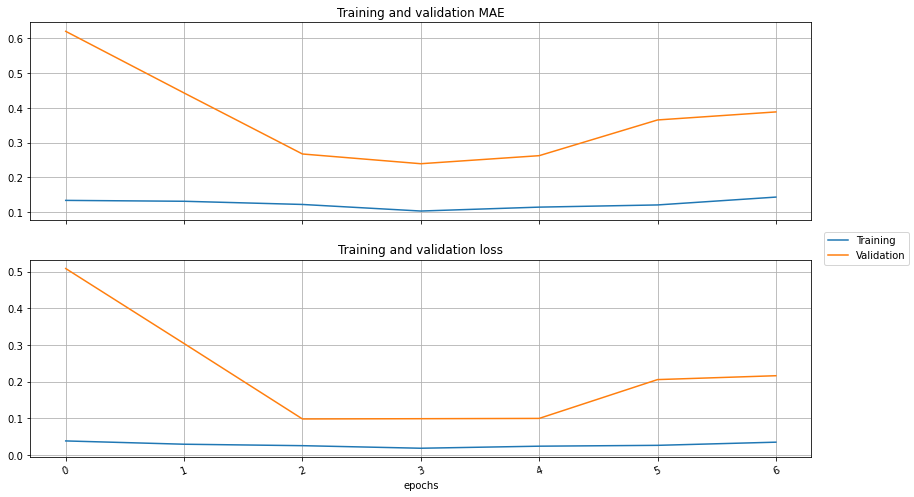

In [23]:
mlp_history, mlp_prediction = compile_and_fit(mlp_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

mlp_results = mlp_prediction.reshape(label_width, len(label_target))

plot_results(label_target, test_target_time[test_entry], test_target[test_entry], mlp_results)

plot_history(mlp_history)

## LSTM RNN model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
257/257 - 25s - loss: 0.0222 - mean_absolute_error: 0.1125 - val_loss: 0.2239 - val_mean_absolute_error: 0.3989

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
257/257 - 25s - loss: 0.0330 - mean_absolute_error: 0.1392 - val_loss: 0.0645 - val_mean_absolute_error: 0.2058

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
257/257 - 25s - loss: 0.0283 - mean_absolute_error: 0.1269 - val_loss: 0.0694 - val_mean_absolute_error: 0.2132

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
257/257 - 24s - loss: 0.0273 - mean_absolute_error: 0.1262 - val_loss: 0.0667 - val_mean_absolute_error: 0.2120

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
257/257 - 25s - loss: 0.0278 - mean_absolute_error: 0.1263 - val_loss: 0

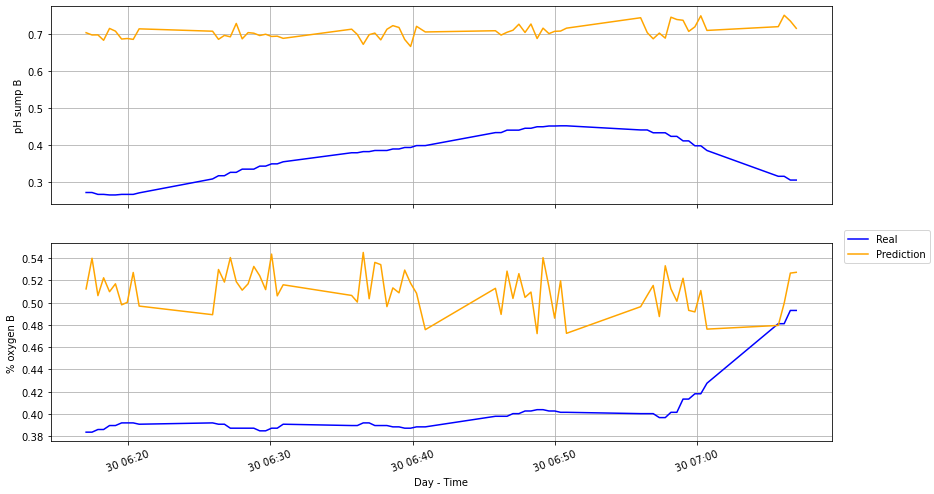

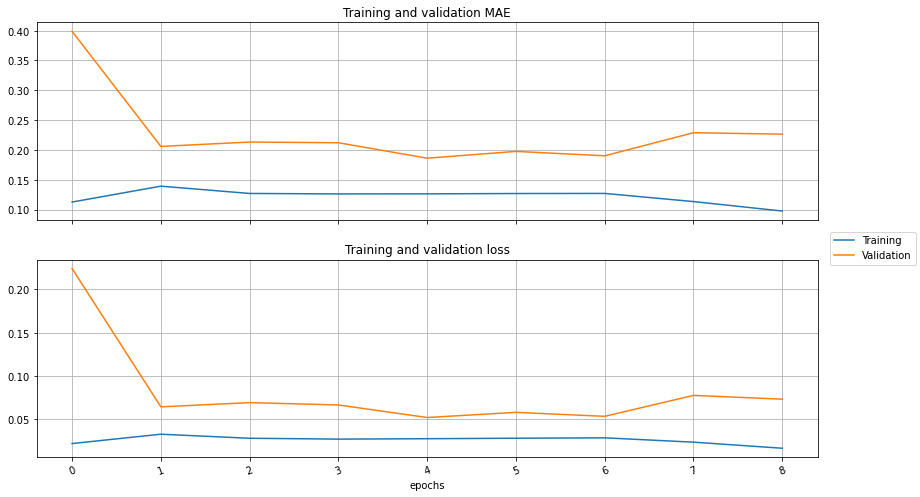

In [24]:
lstm_history, lstm_prediction = compile_and_fit(lstm_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

lstm_results = lstm_prediction.reshape(label_width, len(label_target))

plot_results(label_target, test_target_time[test_entry], test_target[test_entry], lstm_prediction)

plot_history(lstm_history)

## GRU RNN model evaluation


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/15
257/257 - 21s - loss: 0.0233 - mean_absolute_error: 0.1119 - val_loss: 0.1810 - val_mean_absolute_error: 0.3543

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/15
257/257 - 21s - loss: 0.0173 - mean_absolute_error: 0.1021 - val_loss: 0.1267 - val_mean_absolute_error: 0.2923

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/15
257/257 - 21s - loss: 0.0184 - mean_absolute_error: 0.1038 - val_loss: 0.1128 - val_mean_absolute_error: 0.2830

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/15
257/257 - 21s - loss: 0.0162 - mean_absolute_error: 0.0980 - val_loss: 0.0992 - val_mean_absolute_error: 0.2712

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/15
257/257 - 21s - loss: 0.0142 - mean_absolute_error: 0.0915 - val_loss: 0

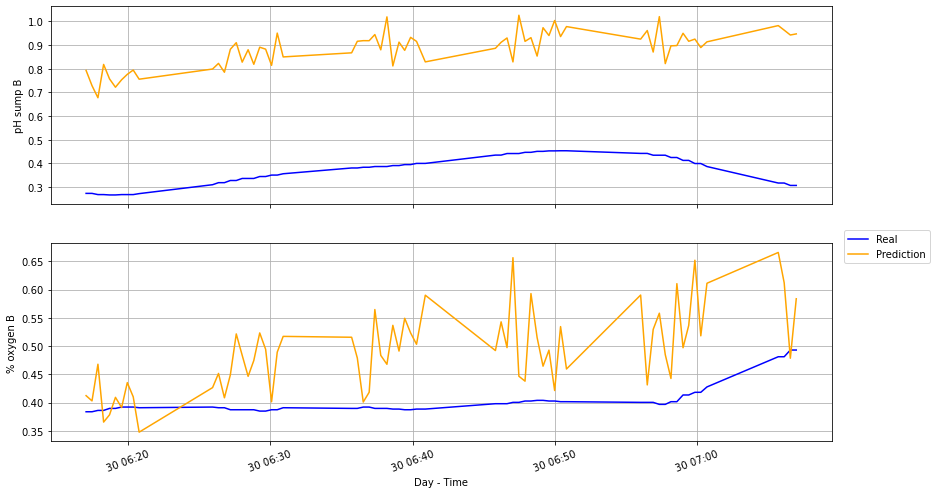

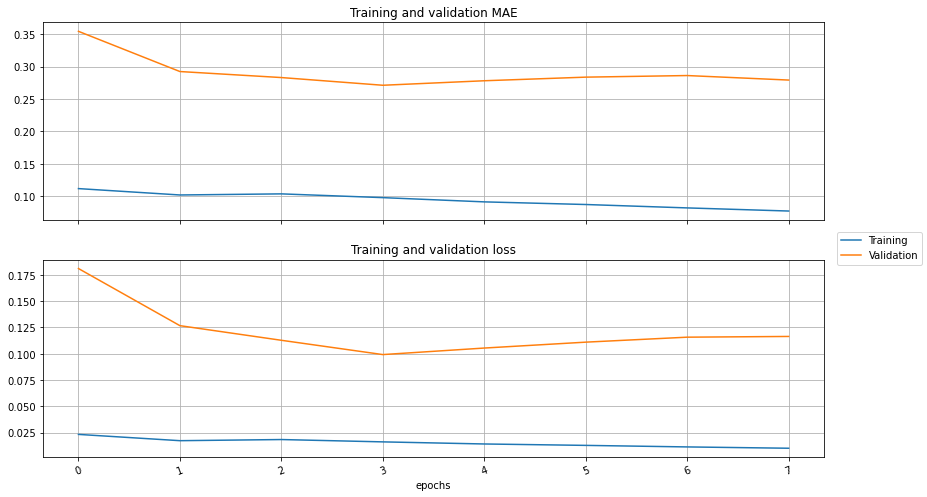

In [25]:
gru_history, gru_prediction = compile_and_fit(gru_model, train_data, train_target, val_data, val_target, test_data, test_target, 
                                                    max_epochs, batch_size, test_entry)

gru_results = gru_prediction.reshape(label_width, len(label_target))

plot_results(label_target, test_target_time[test_entry], test_target[test_entry], gru_prediction)

plot_history(gru_history)

TODO:
- UN-NORMALIZATION FUNCTION
- CLEAN DATA
- ADD MORE LAYERS TO GRU AND LSTM
- TRY ONE NETWORK PER OUTPUT